# Different ML/DL models with ensembling

Training new models...
Loading and preprocessing data...
Creating advanced features...
Total features: 90
Data shape: (1663, 92)
Training set shape: (1130, 48, 90)
Validation set shape: (242, 48, 90)
Test set shape: (243, 48, 90)
Training deep learning models...
Training Transformer...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 464ms/step - loss: 0.6893 - mae: 0.6648 - val_loss: 0.3196 - val_mae: 0.4752 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.4053 - mae: 0.5249 - val_loss: 0.4131 - val_mae: 0.5430 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3570 - mae: 0.4996 - val_loss: 0.4131 - val_mae: 0.5437 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3054 - mae: 0.4665 - val_loss: 0.4223 - val_mae: 0.5498 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3026 - mae: 0.4595 - val_loss: 0.4477 - val_mae: 0.5676 - learnin

Transformer - MAE: 309.9161, RMSE: 370.3877, MAPE: 563.7814%, R²: -0.1053
CNN_LSTM - MAE: 209.2749, RMSE: 251.2472, MAPE: 284.6516%, R²: 0.4914
GRU_Attention - MAE: 218.8194, RMSE: 273.5052, MAPE: 227.8894%, R²: 0.3973


XGBoost - MAE: 98.9393, RMSE: 147.9987, MAPE: 26.8898%, R²: 0.8235
LightGBM - MAE: 100.9567, RMSE: 150.1735, MAPE: 33.0852%, R²: 0.8183
RandomForest - MAE: 93.0964, RMSE: 136.2003, MAPE: 27.3954%, R²: 0.8505
GradientBoosting - MAE: 98.3527, RMSE: 142.2416, MAPE: 38.9878%, R²: 0.8370
Creating ensemble prediction...
Ensemble - MAE: 111.8297, RMSE: 151.4876, MAPE: 96.0481%, R²: 0.8151
Model weights: {'Transformer': 0.06031566742530031, 'CNN_LSTM': 0.08932172190524626, 'GRU_Attention': 0.08542566962174451, 'XGBoost': 0.18893196704063417, 'LightGBM': 0.18515654723616923, 'RandomForest': 0.20078964619991413, 'GradientBoosting': 0.19005878057099135}
Saving all models to saved_models...
Scaler saved to: saved_models/scaler_20250701_100001.pkl
Feature columns saved to: saved_models/feature_cols_20250701_100001.pkl
Transformer model saved to: saved_models/Transformer_20250701_100001.h5
CNN_LSTM model saved to: saved_models/CNN_LSTM_20250701_100001.h5
GRU_Attention model saved to: saved_models/GR

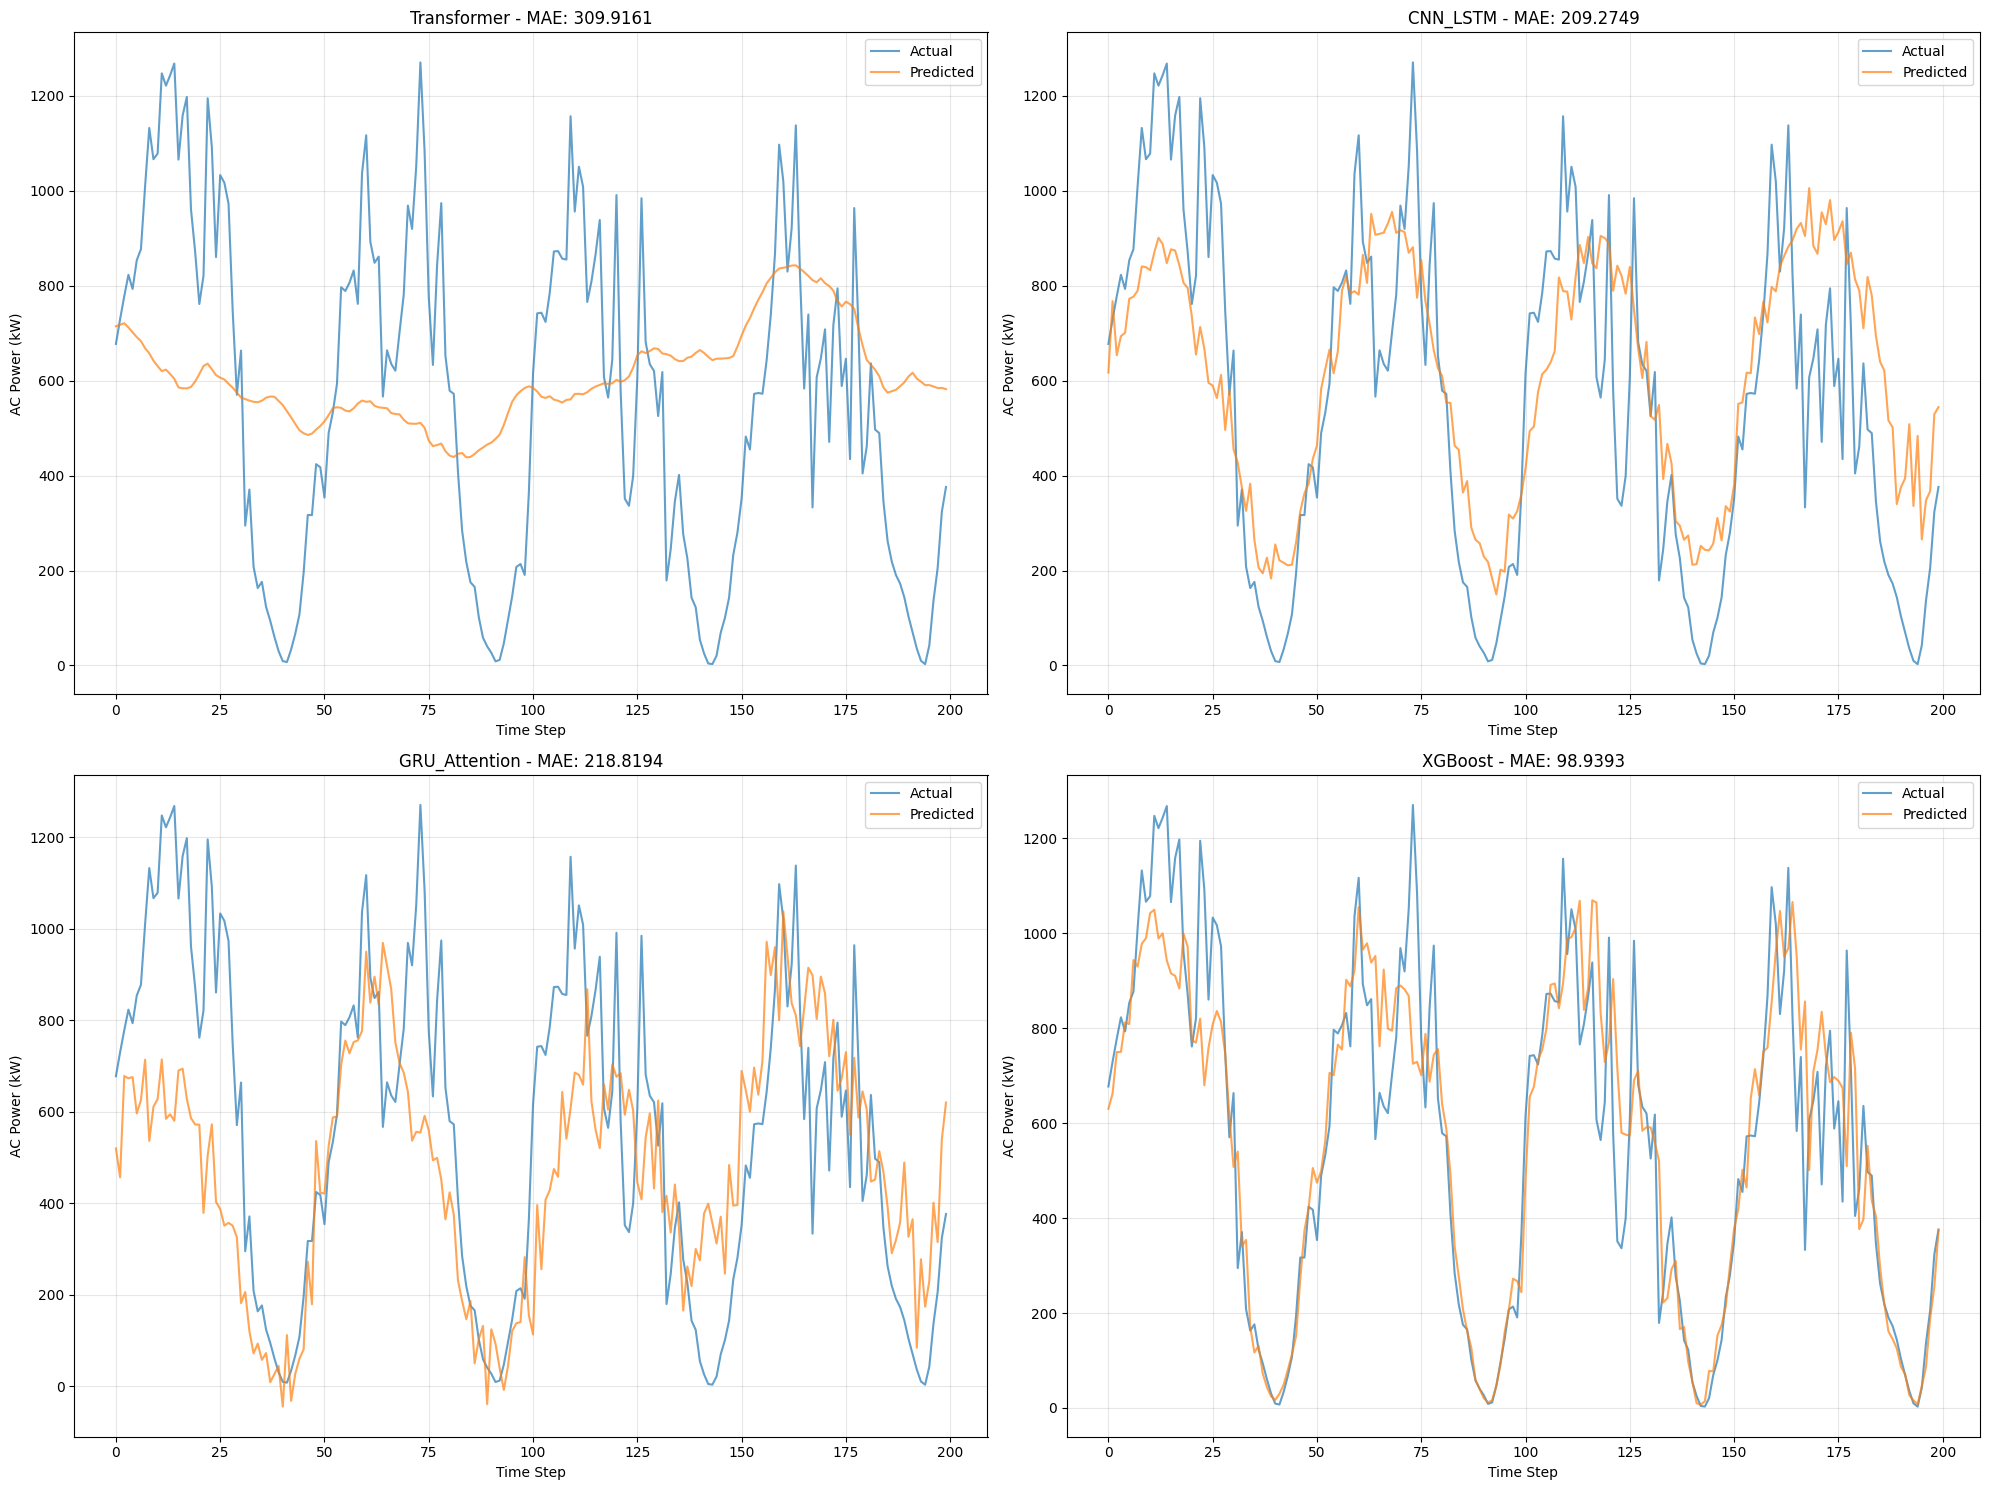

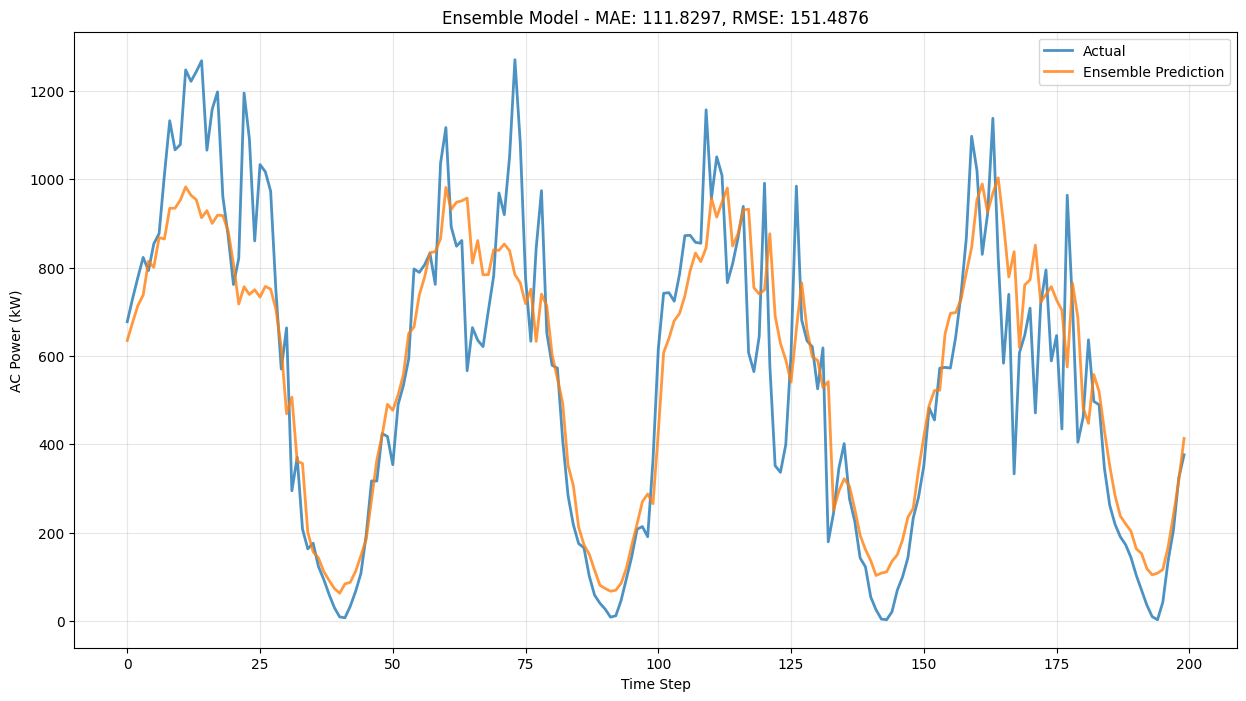


FINAL RESULTS SUMMARY
RandomForest    - MAE:  93.0964, RMSE: 136.2003, MAPE:  27.40%, R²: 0.8505
GradientBoosting - MAE:  98.3527, RMSE: 142.2416, MAPE:  38.99%, R²: 0.8370
XGBoost         - MAE:  98.9393, RMSE: 147.9987, MAPE:  26.89%, R²: 0.8235
LightGBM        - MAE: 100.9567, RMSE: 150.1735, MAPE:  33.09%, R²: 0.8183
CNN_LSTM        - MAE: 209.2749, RMSE: 251.2472, MAPE: 284.65%, R²: 0.4914
GRU_Attention   - MAE: 218.8194, RMSE: 273.5052, MAPE: 227.89%, R²: 0.3973
Transformer     - MAE: 309.9161, RMSE: 370.3877, MAPE: 563.78%, R²: -0.1053
ENSEMBLE        - MAE: 111.8297, RMSE: 151.4876, MAPE:  96.05%, R²: 0.8151

All models saved! Metadata file: saved_models/metadata_20250701_100001.json


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization, GRU, Conv1D, MaxPooling1D, Flatten, Input, Add, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import joblib
import os
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

class SolarPowerForecaster:
    def __init__(self, model_save_dir='saved_models'):
        self.scalers = {}
        self.models = {}
        self.results = {}
        self.model_save_dir = model_save_dir
        self.feature_cols = None
        self.ensemble_weights = {}

        # Create save directory if it doesn't exist
        if not os.path.exists(model_save_dir):
            os.makedirs(model_save_dir)

    def load_and_preprocess_data(self, gen_path, weather_path):
        """Load and preprocess both generation and weather data"""
        print("Loading and preprocessing data...")

        # Load generation data
        gen_data = pd.read_csv(gen_path)
        gen_data['DATE_TIME'] = pd.to_datetime(gen_data['DATE_TIME'], format='%d-%m-%Y %H:%M')

        # Aggregate AC_POWER across inverters and calculate additional features
        gen_agg = gen_data.groupby('DATE_TIME').agg({
            'AC_POWER': ['sum', 'mean', 'std', 'min', 'max'],
            'DC_POWER': ['sum', 'mean', 'std'],
            'DAILY_YIELD': 'mean',
            'TOTAL_YIELD': 'mean'
        }).reset_index()

        # Flatten column names
        gen_agg.columns = ['DATE_TIME', 'total_AC_POWER', 'mean_AC_POWER', 'std_AC_POWER',
                          'min_AC_POWER', 'max_AC_POWER', 'total_DC_POWER', 'mean_DC_POWER',
                          'std_DC_POWER', 'mean_DAILY_YIELD', 'mean_TOTAL_YIELD']

        # Load weather data
        weather_data = pd.read_csv(weather_path)
        weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'])

        # Merge datasets
        data = pd.merge(gen_agg, weather_data[['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']],
                       on='DATE_TIME', how='inner')

        # Fill missing values
        data = data.fillna(method='ffill').fillna(method='bfill')

        return data

    def save_all_models(self, scaler, feature_cols, ensemble_result=None):
        """Save all trained models, scaler, and metadata"""
        print(f"Saving all models to {self.model_save_dir}...")

        # Save timestamp for this training session
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save scaler
        scaler_path = os.path.join(self.model_save_dir, f'scaler_{timestamp}.pkl')
        joblib.dump(scaler, scaler_path)
        print(f"Scaler saved to: {scaler_path}")

        # Save feature columns
        feature_path = os.path.join(self.model_save_dir, f'feature_cols_{timestamp}.pkl')
        with open(feature_path, 'wb') as f:
            pickle.dump(feature_cols, f)
        print(f"Feature columns saved to: {feature_path}")

        # Save each model
        saved_models_info = {}

        for name, model in self.models.items():
            if name in ['Transformer', 'CNN_LSTM', 'GRU_Attention']:
                # Save Keras/TensorFlow models
                model_path = os.path.join(self.model_save_dir, f'{name}_{timestamp}.h5')
                model.save(model_path)
                saved_models_info[name] = {'path': model_path, 'type': 'keras'}
                print(f"{name} model saved to: {model_path}")
            else:
                # Save sklearn/xgboost/lightgbm models
                model_path = os.path.join(self.model_save_dir, f'{name}_{timestamp}.pkl')
                joblib.dump(model, model_path)
                saved_models_info[name] = {'path': model_path, 'type': 'sklearn'}
                print(f"{name} model saved to: {model_path}")

        # Save ensemble weights if available
        if ensemble_result and 'weights' in ensemble_result:
            weights_path = os.path.join(self.model_save_dir, f'ensemble_weights_{timestamp}.json')
            with open(weights_path, 'w') as f:
                json.dump(ensemble_result['weights'], f, indent=2)
            print(f"Ensemble weights saved to: {weights_path}")
            saved_models_info['ensemble_weights'] = weights_path

        # Save results if available
        if self.results:
            results_path = os.path.join(self.model_save_dir, f'results_{timestamp}.pkl')
            with open(results_path, 'wb') as f:
                pickle.dump(self.results, f)
            print(f"Results saved to: {results_path}")
            saved_models_info['results'] = results_path

        # Save metadata
        metadata = {
            'timestamp': timestamp,
            'scaler_path': scaler_path,
            'feature_cols_path': feature_path,
            'models': saved_models_info,
            'n_features': len(feature_cols)
        }

        metadata_path = os.path.join(self.model_save_dir, f'metadata_{timestamp}.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"Metadata saved to: {metadata_path}")

        # Save latest metadata (for easy loading)
        latest_metadata_path = os.path.join(self.model_save_dir, 'latest_metadata.json')
        with open(latest_metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"Latest metadata saved to: {latest_metadata_path}")

        print(f"All models and components saved successfully with timestamp: {timestamp}")
        return metadata_path

    def load_all_models(self, metadata_path=None):
        """Load all models from saved files"""
        if metadata_path is None:
            metadata_path = os.path.join(self.model_save_dir, 'latest_metadata.json')

        print(f"Loading models from metadata: {metadata_path}")

        # Load metadata
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        # Load scaler
        scaler = joblib.load(metadata['scaler_path'])
        print(f"Scaler loaded from: {metadata['scaler_path']}")

        # Load feature columns
        with open(metadata['feature_cols_path'], 'rb') as f:
            feature_cols = pickle.load(f)
        print(f"Feature columns loaded from: {metadata['feature_cols_path']}")

        # Load models
        self.models = {}
        for name, model_info in metadata['models'].items():
            if name in ['ensemble_weights', 'results']:
                continue

            if model_info['type'] == 'keras':
                model = load_model(model_info['path'])
                print(f"{name} (Keras) model loaded from: {model_info['path']}")
            else:
                model = joblib.load(model_info['path'])
                print(f"{name} (Sklearn) model loaded from: {model_info['path']}")

            self.models[name] = model

        # Load ensemble weights if available
        if 'ensemble_weights' in metadata['models']:
            with open(metadata['models']['ensemble_weights'], 'r') as f:
                self.ensemble_weights = json.load(f)
            print(f"Ensemble weights loaded from: {metadata['models']['ensemble_weights']}")

        # Load results if available
        if 'results' in metadata['models']:
            with open(metadata['models']['results'], 'rb') as f:
                self.results = pickle.load(f)
            print(f"Results loaded from: {metadata['models']['results']}")

        self.feature_cols = feature_cols
        print(f"Successfully loaded {len(self.models)} models")

        return scaler, feature_cols

    def predict_with_loaded_models(self, X_test, scaler, model_type='all'):
        """Make predictions using loaded models"""
        if not self.models:
            raise ValueError("No models loaded. Please load models first using load_all_models()")

        predictions = {}

        for name, model in self.models.items():
            try:
                if name in ['Transformer', 'CNN_LSTM', 'GRU_Attention']:
                    if model_type in ['deep', 'all']:
                        y_pred = model.predict(X_test, verbose=0)
                        predictions[name] = y_pred.flatten()
                else:
                    if model_type in ['ensemble', 'all']:
                        # For ensemble models, reshape X_test to 2D
                        X_test_2d = X_test.reshape(X_test.shape[0], -1)
                        y_pred = model.predict(X_test_2d)
                        predictions[name] = y_pred.flatten()
            except Exception as e:
                print(f"Error predicting with {name}: {str(e)}")
                continue

        return predictions

    def create_ensemble_prediction_from_loaded(self, predictions, actual_values=None):
        """Create ensemble prediction using loaded weights"""
        if not self.ensemble_weights:
            print("No ensemble weights found. Creating equal weight ensemble...")
            # Create equal weights
            weights = {name: 1.0/len(predictions) for name in predictions.keys()}
        else:
            weights = self.ensemble_weights
            # Filter weights for available predictions
            weights = {name: weight for name, weight in weights.items() if name in predictions}
            # Normalize weights
            total_weight = sum(weights.values())
            weights = {name: weight/total_weight for name, weight in weights.items()}

        # Create weighted ensemble
        ensemble_pred = np.zeros_like(list(predictions.values())[0])

        for name, pred in predictions.items():
            if name in weights:
                ensemble_pred += weights[name] * pred

        # Calculate metrics if actual values provided
        if actual_values is not None:
            mae = mean_absolute_error(actual_values, ensemble_pred)
            rmse = np.sqrt(mean_squared_error(actual_values, ensemble_pred))
            mape = np.mean(np.abs((actual_values - ensemble_pred) / (actual_values + 1e-10))) * 100
            r2 = r2_score(actual_values, ensemble_pred)

            print(f'Ensemble - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%, R²: {r2:.4f}')

            return ensemble_pred, {
                'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2,
                'weights': weights
            }

        return ensemble_pred, {'weights': weights}

    def list_saved_models(self):
        """List all saved model sessions"""
        if not os.path.exists(self.model_save_dir):
            print(f"No saved models directory found: {self.model_save_dir}")
            return []

        metadata_files = [f for f in os.listdir(self.model_save_dir) if f.startswith('metadata_') and f.endswith('.json')]

        print(f"Found {len(metadata_files)} saved model sessions:")
        sessions = []

        for metadata_file in sorted(metadata_files):
            metadata_path = os.path.join(self.model_save_dir, metadata_file)
            try:
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                timestamp = metadata['timestamp']
                n_models = len([k for k in metadata['models'].keys() if k not in ['ensemble_weights', 'results']])
                print(f"  - {timestamp}: {n_models} models")
                sessions.append({'timestamp': timestamp, 'path': metadata_path, 'n_models': n_models})
            except Exception as e:
                print(f"  - Error reading {metadata_file}: {str(e)}")

        return sessions

    def create_advanced_features(self, data):
        """Create comprehensive feature engineering"""
        print("Creating advanced features...")

        # Time-based features
        data['hour'] = data['DATE_TIME'].dt.hour
        data['day'] = data['DATE_TIME'].dt.day
        data['month'] = data['DATE_TIME'].dt.month
        data['day_of_year'] = data['DATE_TIME'].dt.dayofyear
        data['week_of_year'] = data['DATE_TIME'].dt.isocalendar().week
        data['is_weekend'] = data['DATE_TIME'].dt.weekday >= 5

        # Cyclical encoding
        data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
        data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
        data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
        data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
        data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
        data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
        data['doy_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
        data['doy_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)

        # Weather-based features
        data['temp_diff'] = data['MODULE_TEMPERATURE'] - data['AMBIENT_TEMPERATURE']
        data['temp_ratio'] = data['MODULE_TEMPERATURE'] / (data['AMBIENT_TEMPERATURE'] + 1e-8)
        data['irradiation_temp_interaction'] = data['IRRADIATION'] * data['MODULE_TEMPERATURE']
        data['power_efficiency'] = data['total_AC_POWER'] / (data['total_DC_POWER'] + 1e-8)

        # Lag features
        for lag in [1, 2, 3, 6, 12, 24]:
            data[f'AC_POWER_lag_{lag}'] = data['total_AC_POWER'].shift(lag)
            data[f'IRRADIATION_lag_{lag}'] = data['IRRADIATION'].shift(lag)
            data[f'MODULE_TEMP_lag_{lag}'] = data['MODULE_TEMPERATURE'].shift(lag)

        # Rolling window features
        for window in [3, 6, 12, 24]:
            data[f'AC_POWER_rolling_mean_{window}'] = data['total_AC_POWER'].rolling(window=window).mean()
            data[f'AC_POWER_rolling_std_{window}'] = data['total_AC_POWER'].rolling(window=window).std()
            data[f'IRRADIATION_rolling_mean_{window}'] = data['IRRADIATION'].rolling(window=window).mean()
            data[f'MODULE_TEMP_rolling_mean_{window}'] = data['MODULE_TEMPERATURE'].rolling(window=window).mean()

        # Fourier features for multiple periodicities
        self._add_fourier_features(data, period=96, n_terms=8, prefix='daily')  # Daily pattern
        self._add_fourier_features(data, period=672, n_terms=4, prefix='weekly')  # Weekly pattern

        # Clear sky model approximation
        data['clear_sky_power'] = self._calculate_clear_sky_power(data)
        data['power_clear_sky_ratio'] = data['total_AC_POWER'] / (data['clear_sky_power'] + 1e-8)

        # Remove rows with NaN values created by lag and rolling features
        data = data.dropna().reset_index(drop=True)

        return data

    def create_advanced_features(self, data):
        """Create comprehensive feature engineering"""
        print("Creating advanced features...")

        # Time-based features
        data['hour'] = data['DATE_TIME'].dt.hour
        data['day'] = data['DATE_TIME'].dt.day
        data['month'] = data['DATE_TIME'].dt.month
        data['day_of_year'] = data['DATE_TIME'].dt.dayofyear
        data['week_of_year'] = data['DATE_TIME'].dt.isocalendar().week
        data['is_weekend'] = data['DATE_TIME'].dt.weekday >= 5

        # Cyclical encoding
        data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
        data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
        data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
        data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
        data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
        data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
        data['doy_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
        data['doy_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)

        # Weather-based features
        data['temp_diff'] = data['MODULE_TEMPERATURE'] - data['AMBIENT_TEMPERATURE']
        data['temp_ratio'] = data['MODULE_TEMPERATURE'] / (data['AMBIENT_TEMPERATURE'] + 1e-8)
        data['irradiation_temp_interaction'] = data['IRRADIATION'] * data['MODULE_TEMPERATURE']
        data['power_efficiency'] = data['total_AC_POWER'] / (data['total_DC_POWER'] + 1e-8)

        # Lag features
        for lag in [1, 2, 3, 6, 12, 24]:
            data[f'AC_POWER_lag_{lag}'] = data['total_AC_POWER'].shift(lag)
            data[f'IRRADIATION_lag_{lag}'] = data['IRRADIATION'].shift(lag)
            data[f'MODULE_TEMP_lag_{lag}'] = data['MODULE_TEMPERATURE'].shift(lag)

        # Rolling window features
        for window in [3, 6, 12, 24]:
            data[f'AC_POWER_rolling_mean_{window}'] = data['total_AC_POWER'].rolling(window=window).mean()
            data[f'AC_POWER_rolling_std_{window}'] = data['total_AC_POWER'].rolling(window=window).std()
            data[f'IRRADIATION_rolling_mean_{window}'] = data['IRRADIATION'].rolling(window=window).mean()
            data[f'MODULE_TEMP_rolling_mean_{window}'] = data['MODULE_TEMPERATURE'].rolling(window=window).mean()

        # Fourier features for multiple periodicities
        self._add_fourier_features(data, period=96, n_terms=8, prefix='daily')  # Daily pattern
        self._add_fourier_features(data, period=672, n_terms=4, prefix='weekly')  # Weekly pattern

        # Clear sky model approximation
        data['clear_sky_power'] = self._calculate_clear_sky_power(data)
        data['power_clear_sky_ratio'] = data['total_AC_POWER'] / (data['clear_sky_power'] + 1e-8)

        # Remove rows with NaN values created by lag and rolling features
        data = data.dropna().reset_index(drop=True)

        return data

    def _add_fourier_features(self, data, period, n_terms, prefix):
        """Add Fourier features for specific periodicity"""
        data['time_index'] = range(len(data))
        for i in range(1, n_terms + 1):
            data[f'{prefix}_sin_{i}'] = np.sin(2 * np.pi * i * data['time_index'] / period)
            data[f'{prefix}_cos_{i}'] = np.cos(2 * np.pi * i * data['time_index'] / period)
        data.drop('time_index', axis=1, inplace=True)

    def _calculate_clear_sky_power(self, data):
        """Simple clear sky power estimation"""
        # Simplified clear sky model based on solar elevation
        solar_elevation = np.maximum(0, np.sin(2 * np.pi * (data['hour'] - 6) / 12))
        clear_sky_irradiance = 1000 * solar_elevation  # Simplified
        return clear_sky_irradiance * 0.2  # Simplified efficiency factor

    def prepare_sequences(self, data, features, target, seq_length=48):
        """Prepare sequences for time series models"""
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[features].iloc[i:i + seq_length].values)
            y.append(data[target].iloc[i + seq_length])
        return np.array(X), np.array(y)

    def build_transformer_model(self, seq_length, n_features):
        """Build a Transformer-based model"""
        inputs = Input(shape=(seq_length, n_features))

        # Multi-head attention layers
        attn1 = MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.1)(inputs, inputs)
        attn1 = LayerNormalization()(attn1 + inputs)

        attn2 = MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.1)(attn1, attn1)
        attn2 = LayerNormalization()(attn2 + attn1)

        # Feed forward network
        ffn = Dense(256, activation='relu')(attn2)
        ffn = Dropout(0.1)(ffn)
        ffn = Dense(n_features)(ffn)
        ffn = LayerNormalization()(ffn + attn2)

        # Global average pooling and output
        x = tf.keras.layers.GlobalAveragePooling1D()(ffn)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)

        model = Model(inputs, outputs)
        return model

    def build_cnn_lstm_model(self, seq_length, n_features):
        """Build a CNN-LSTM hybrid model"""
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, n_features)),
            BatchNormalization(),
            Conv1D(filters=64, kernel_size=3, activation='relu'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),

            Conv1D(filters=128, kernel_size=3, activation='relu'),
            BatchNormalization(),
            Conv1D(filters=128, kernel_size=3, activation='relu'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),

            LSTM(100, return_sequences=True, dropout=0.2),
            LSTM(50, dropout=0.2),

            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        return model

    def build_gru_attention_model(self, seq_length, n_features):
        """Build a GRU model with attention mechanism"""
        inputs = Input(shape=(seq_length, n_features))

        # GRU layers
        gru1 = GRU(128, return_sequences=True, dropout=0.2)(inputs)
        gru2 = GRU(64, return_sequences=True, dropout=0.2)(gru1)

        # Attention mechanism
        attention = MultiHeadAttention(num_heads=4, key_dim=32)(gru2, gru2)
        attention = LayerNormalization()(attention + gru2)

        # Global pooling and dense layers
        x = tf.keras.layers.GlobalAveragePooling1D()(attention)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)

        model = Model(inputs, outputs)
        return model

    def train_deep_models(self, X_train, y_train, X_val, y_val, seq_length, n_features):
        """Train multiple deep learning models"""
        print("Training deep learning models...")

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7)

        models_config = {
            'Transformer': self.build_transformer_model(seq_length, n_features),
            'CNN_LSTM': self.build_cnn_lstm_model(seq_length, n_features),
            'GRU_Attention': self.build_gru_attention_model(seq_length, n_features)
        }

        for name, model in models_config.items():
            print(f"Training {name}...")

            # Compile with different optimizers for different models
            if name == 'Transformer':
                optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
            else:
                optimizer = Adam(learning_rate=0.001)

            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=100,
                batch_size=64,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )

            self.models[name] = model

    def train_ensemble_models(self, X_train, y_train):
        """Train ensemble models"""
        print("Training ensemble models...")

        ensemble_models = {
            'XGBoost': xgb.XGBRegressor(
                n_estimators=1000,
                max_depth=8,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            ),
            'LightGBM': lgb.LGBMRegressor(
                n_estimators=1000,
                max_depth=8,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                verbose=-1
            ),
            'RandomForest': RandomForestRegressor(
                n_estimators=500,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            ),
            'GradientBoosting': GradientBoostingRegressor(
                n_estimators=500,
                max_depth=8,
                learning_rate=0.1,
                random_state=42
            )
        }

        for name, model in ensemble_models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            self.models[name] = model

    def predict_and_evaluate(self, X_test, y_test, scaler, model_type='deep'):
        """Make predictions and evaluate models"""
        predictions = {}

        for name, model in self.models.items():
            if model_type == 'deep' and name in ['Transformer', 'CNN_LSTM', 'GRU_Attention']:
                y_pred = model.predict(X_test, verbose=0)
            elif model_type == 'ensemble' and name not in ['Transformer', 'CNN_LSTM', 'GRU_Attention']:
                # For ensemble models, we need to reshape X_test
                X_test_2d = X_test.reshape(X_test.shape[0], -1)
                y_pred = model.predict(X_test_2d)
            else:
                continue

            predictions[name] = y_pred.flatten()

        # Inverse transform predictions
        results = {}
        for name, y_pred in predictions.items():
            # Create dummy array for inverse transformation
            dummy_array = np.zeros((len(y_pred), scaler.n_features_in_))
            dummy_array[:, 0] = y_pred
            y_pred_rescaled = scaler.inverse_transform(dummy_array)[:, 0]

            # Do the same for actual values
            dummy_array_actual = np.zeros((len(y_test), scaler.n_features_in_))
            dummy_array_actual[:, 0] = y_test
            y_test_rescaled = scaler.inverse_transform(dummy_array_actual)[:, 0]

            # Calculate metrics
            mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
            rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
            mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / (y_test_rescaled + 1e-10))) * 100
            r2 = r2_score(y_test_rescaled, y_pred_rescaled)

            results[name] = {
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'predictions': y_pred_rescaled,
                'actual': y_test_rescaled
            }

            print(f'{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%, R²: {r2:.4f}')

        return results

    def create_ensemble_prediction(self, results):
        """Create ensemble prediction from multiple models"""
        print("Creating ensemble prediction...")

        # Weight models based on their performance (inverse of MAE)
        weights = {}
        total_weight = 0

        for name, result in results.items():
            weight = 1.0 / (result['MAE'] + 1e-10)
            weights[name] = weight
            total_weight += weight

        # Normalize weights
        for name in weights:
            weights[name] /= total_weight

        # Create weighted ensemble
        ensemble_pred = np.zeros_like(list(results.values())[0]['predictions'])
        actual = list(results.values())[0]['actual']

        for name, result in results.items():
            ensemble_pred += weights[name] * result['predictions']

        # Calculate ensemble metrics
        mae = mean_absolute_error(actual, ensemble_pred)
        rmse = np.sqrt(mean_squared_error(actual, ensemble_pred))
        mape = np.mean(np.abs((actual - ensemble_pred) / (actual + 1e-10))) * 100
        r2 = r2_score(actual, ensemble_pred)

        ensemble_result = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2,
            'predictions': ensemble_pred,
            'actual': actual,
            'weights': weights
        }

        print(f'Ensemble - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%, R²: {r2:.4f}')
        print(f'Model weights: {weights}')

        return ensemble_result

    def plot_results(self, results, ensemble_result=None):
        """Plot prediction results"""
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))

        # Plot individual model results
        for i, (name, result) in enumerate(results.items()):
            if i >= 4:  # Only plot first 4 models
                break
            row, col = i // 2, i % 2

            axes[row, col].plot(result['actual'][:200], label='Actual', alpha=0.7)
            axes[row, col].plot(result['predictions'][:200], label='Predicted', alpha=0.7)
            axes[row, col].set_title(f'{name} - MAE: {result["MAE"]:.4f}')
            axes[row, col].set_xlabel('Time Step')
            axes[row, col].set_ylabel('AC Power (kW)')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Plot ensemble result if available
        if ensemble_result:
            plt.figure(figsize=(15, 8))
            plt.plot(ensemble_result['actual'][:200], label='Actual', alpha=0.8, linewidth=2)
            plt.plot(ensemble_result['predictions'][:200], label='Ensemble Prediction', alpha=0.8, linewidth=2)
            plt.title(f'Ensemble Model - MAE: {ensemble_result["MAE"]:.4f}, RMSE: {ensemble_result["RMSE"]:.4f}')
            plt.xlabel('Time Step')
            plt.ylabel('AC Power (kW)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

# Main execution function
def main():
    # Initialize forecaster
    forecaster = SolarPowerForecaster()

    # Load and preprocess data
    gen_path = 'Plant1_filtered.csv'
    weather_path = 'Plant1_Weather_filtered.csv'

    data = forecaster.load_and_preprocess_data(gen_path, weather_path)
    data = forecaster.create_advanced_features(data)

    # Define features and target
    feature_cols = [col for col in data.columns if col not in ['DATE_TIME', 'total_AC_POWER']]
    target_col = 'total_AC_POWER'

    print(f"Total features: {len(feature_cols)}")
    print(f"Data shape: {data.shape}")

    # Scale the data
    scaler = RobustScaler()  # Using RobustScaler as it's less sensitive to outliers
    scaled_features = scaler.fit_transform(data[feature_cols + [target_col]])

    # Create scaled dataframe
    scaled_df = pd.DataFrame(scaled_features, columns=feature_cols + [target_col])
    scaled_df['DATE_TIME'] = data['DATE_TIME'].values

    # Prepare sequences for deep learning models
    seq_length = 48  # 12 hours
    X_seq, y_seq = forecaster.prepare_sequences(scaled_df, feature_cols, target_col, seq_length)

    # Split data chronologically
    train_size = int(0.7 * len(X_seq))
    val_size = int(0.15 * len(X_seq))

    X_train_seq = X_seq[:train_size]
    y_train_seq = y_seq[:train_size]
    X_val_seq = X_seq[train_size:train_size + val_size]
    y_val_seq = y_seq[train_size:train_size + val_size]
    X_test_seq = X_seq[train_size + val_size:]
    y_test_seq = y_seq[train_size + val_size:]

    # Prepare data for ensemble models (2D format)
    X_train_2d = X_train_seq.reshape(X_train_seq.shape[0], -1)
    X_val_2d = X_val_seq.reshape(X_val_seq.shape[0], -1)
    X_test_2d = X_test_seq.reshape(X_test_seq.shape[0], -1)

    print(f"Training set shape: {X_train_seq.shape}")
    print(f"Validation set shape: {X_val_seq.shape}")
    print(f"Test set shape: {X_test_seq.shape}")

    # Train deep learning models
    forecaster.train_deep_models(X_train_seq, y_train_seq, X_val_seq, y_val_seq,
                                seq_length, len(feature_cols))

    # Train ensemble models
    forecaster.train_ensemble_models(X_train_2d, y_train_seq)

    # Evaluate deep learning models
    deep_results = forecaster.predict_and_evaluate(X_test_seq, y_test_seq, scaler, 'deep')

    # Evaluate ensemble models
    ensemble_results = forecaster.predict_and_evaluate(X_test_seq, y_test_seq, scaler, 'ensemble')

    # Combine all results
    all_results = {**deep_results, **ensemble_results}
    forecaster.results = all_results

    # Create ensemble prediction
    ensemble_result = forecaster.create_ensemble_prediction(all_results)

    # Save all models and results
    metadata_path = forecaster.save_all_models(scaler, feature_cols, ensemble_result)

    # Plot results
    forecaster.plot_results(all_results, ensemble_result)

    # Print summary
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)

    sorted_results = sorted(all_results.items(), key=lambda x: x[1]['MAE'])

    for name, result in sorted_results:
        print(f"{name:15s} - MAE: {result['MAE']:8.4f}, RMSE: {result['RMSE']:8.4f}, "
              f"MAPE: {result['MAPE']:6.2f}%, R²: {result['R2']:6.4f}")

    print(f"{'ENSEMBLE':15s} - MAE: {ensemble_result['MAE']:8.4f}, RMSE: {ensemble_result['RMSE']:8.4f}, "
          f"MAPE: {ensemble_result['MAPE']:6.2f}%, R²: {ensemble_result['R2']:6.4f}")

    print(f"\nAll models saved! Metadata file: {metadata_path}")

    return forecaster, all_results, ensemble_result

# Function to load and use saved models
def load_and_predict():
    """Function to load saved models and make predictions"""
    forecaster = SolarPowerForecaster()

    # List available saved models
    sessions = forecaster.list_saved_models()

    if not sessions:
        print("No saved models found!")
        return None

    # Load the latest models
    print("Loading latest saved models...")
    scaler, feature_cols = forecaster.load_all_models()

    print("Models loaded successfully!")
    print(f"Available models: {list(forecaster.models.keys())}")
    print(f"Number of features: {len(feature_cols)}")

    return forecaster, scaler, feature_cols

# Function to make predictions on new data
def predict_new_data(forecaster, scaler, feature_cols, new_data_path, seq_length=48):
    """Make predictions on new data using loaded models"""
    # Load new data (same preprocessing as training)
    # This is a placeholder - you'd implement the same preprocessing pipeline
    print(f"This function would load new data from {new_data_path}")
    print("Apply the same preprocessing and feature engineering...")
    print("Then make predictions using the loaded models")

    # Example of how to use loaded models:
    # predictions = forecaster.predict_with_loaded_models(X_new, scaler)
    # ensemble_pred, metrics = forecaster.create_ensemble_prediction_from_loaded(predictions, y_actual)

    return None

if __name__ == "__main__":
    # Choose whether to train new models or load existing ones
    train_new = True  # Set to False to load existing models

    if train_new:
        print("Training new models...")
        forecaster, results, ensemble_result = main()
    else:
        print("Loading existing models...")
        forecaster, scaler, feature_cols = load_and_predict()

        # Example: Make predictions on test data
        # You would implement the data loading and prediction here

 # Bi-LSTM with Fourier Approximation without CV and Tuning


Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - loss: 0.4406 - val_loss: 0.1370
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1874 - val_loss: 0.0927
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1315 - val_loss: 0.0709
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1078 - val_loss: 0.0694
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1152 - val_loss: 0.1044
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1003 - val_loss: 0.0838
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0927 - val_loss: 0.0812
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0925 - val_loss: 0.0564
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0856 - val_loss: 0.0609
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0819 - val_loss: 0.0450
Epoch 11/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0813 - val_loss: 0.0457
Epoch 12/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/st

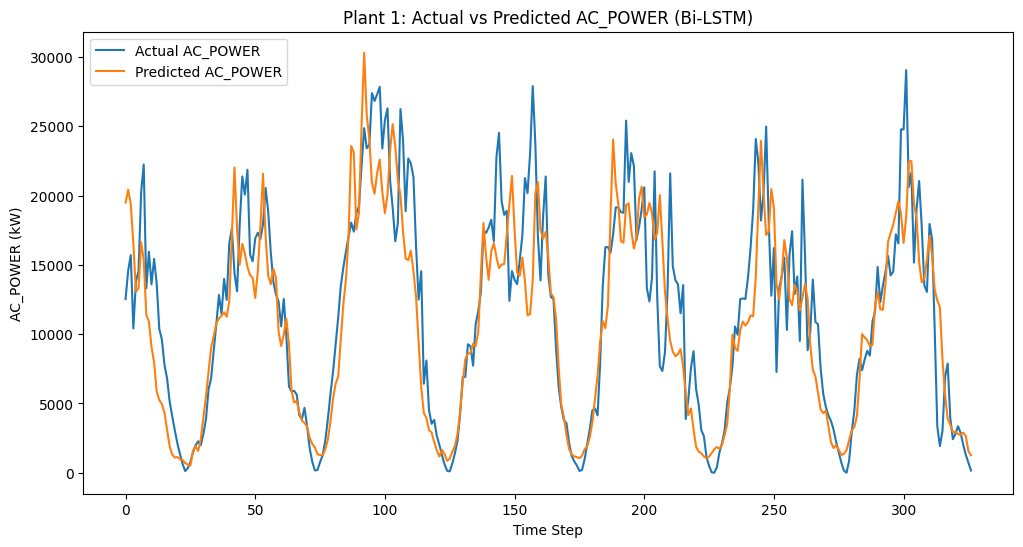

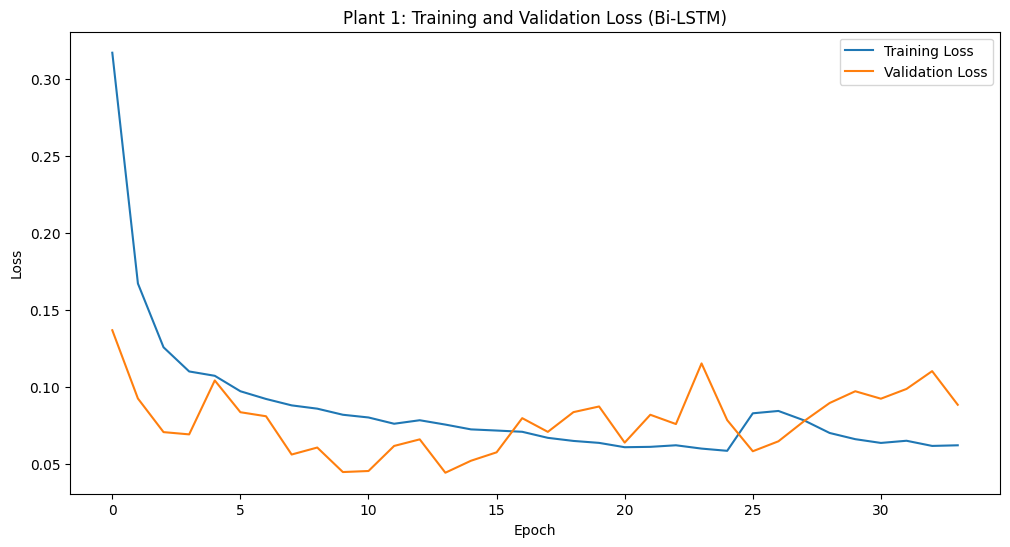

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Custom MAE loss function
def custom_mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# Load and preprocess generation data
gen_data = pd.read_csv('/content/Plant1_filtered.csv')  # Adjust path
gen_data['DATE_TIME'] = pd.to_datetime(gen_data['DATE_TIME'], format='%d-%m-%Y %H:%M')

# Aggregate AC_POWER across inverters
gen_agg = gen_data.groupby('DATE_TIME')['AC_POWER'].sum().reset_index()
gen_agg.columns = ['DATE_TIME', 'total_AC_POWER']

# Load and preprocess weather data
weather_data = pd.read_csv('/content/Plant1_Weather_filtered.csv')  # Adjust path
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'])

# Merge datasets
data = pd.merge(gen_agg, weather_data[['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']],
                on='DATE_TIME', how='inner')

# Data cleaning: Remove missing values and outliers
data = data.dropna()
data = data[(data['total_AC_POWER'] >= 0) & (data['IRRADIATION'] >= 0)]  # Remove negative values
q1, q3 = data['total_AC_POWER'].quantile([0.25, 0.75])
iqr = q3 - q1
data = data[(data['total_AC_POWER'] >= q1 - 1.5 * iqr) & (data['total_AC_POWER'] <= q3 + 1.5 * iqr)]  # Remove outliers

# Log transformation for target to handle skewed distribution
data['log_AC_POWER'] = np.log1p(data['total_AC_POWER'])  # log1p to handle zero values

# Add lag features for weather variables and AC_POWER (2 hours = 8 lags)
for lag in range(1, 9):
    data[f'AMBIENT_TEMPERATURE_lag{lag}'] = data['AMBIENT_TEMPERATURE'].shift(lag)
    data[f'MODULE_TEMPERATURE_lag{lag}'] = data['MODULE_TEMPERATURE'].shift(lag)
    data[f'IRRADIATION_lag{lag}'] = data['IRRADIATION'].shift(lag)
    data[f'total_AC_POWER_lag{lag}'] = data['total_AC_POWER'].shift(lag)
data = data.dropna()  # Remove rows with NaN from lagging

# Add time features
data['hour'] = data['DATE_TIME'].dt.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

# Add Fourier features for daily periodicity (96 time steps = 24 hours * 4 per hour)
def generate_fourier_features(df, period, n_terms):
    df = df.copy()
    df['time_index'] = range(len(df))
    for i in range(1, n_terms + 1):
        df[f'sin_{i}'] = np.sin(2 * np.pi * i * df['time_index'] / period)
        df[f'cos_{i}'] = np.cos(2 * np.pi * i * df['time_index'] / period)
    df = df.drop(columns=['time_index'])
    return df

period = 96  # Daily periodicity for 15-minute intervals
n_terms = 25  # Increased for finer periodicity capture
data = generate_fourier_features(data, period, n_terms)

# Define features and target
features = ['log_AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
            'AMBIENT_TEMPERATURE_lag1', 'AMBIENT_TEMPERATURE_lag2', 'AMBIENT_TEMPERATURE_lag3', 'AMBIENT_TEMPERATURE_lag4',
            'AMBIENT_TEMPERATURE_lag5', 'AMBIENT_TEMPERATURE_lag6', 'AMBIENT_TEMPERATURE_lag7', 'AMBIENT_TEMPERATURE_lag8',
            'MODULE_TEMPERATURE_lag1', 'MODULE_TEMPERATURE_lag2', 'MODULE_TEMPERATURE_lag3', 'MODULE_TEMPERATURE_lag4',
            'MODULE_TEMPERATURE_lag5', 'MODULE_TEMPERATURE_lag6', 'MODULE_TEMPERATURE_lag7', 'MODULE_TEMPERATURE_lag8',
            'IRRADIATION_lag1', 'IRRADIATION_lag2', 'IRRADIATION_lag3', 'IRRADIATION_lag4',
            'IRRADIATION_lag5', 'IRRADIATION_lag6', 'IRRADIATION_lag7', 'IRRADIATION_lag8',
            'total_AC_POWER_lag1', 'total_AC_POWER_lag2', 'total_AC_POWER_lag3', 'total_AC_POWER_lag4',
            'total_AC_POWER_lag5', 'total_AC_POWER_lag6', 'total_AC_POWER_lag7', 'total_AC_POWER_lag8',
            'hour_sin', 'hour_cos'] + [f'sin_{i}' for i in range(1, n_terms + 1)] + [f'cos_{i}' for i in range(1, n_terms + 1)]
target = 'log_AC_POWER'

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)
scaled_df['DATE_TIME'] = data['DATE_TIME']
scaled_df[target] = scaled_data[:, 0]  # Target is first column (log_AC_POWER)

# Create sequences
def create_sequences(df, seq_length, target_col):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[features].iloc[i:i + seq_length].values)
        y.append(df[target_col].iloc[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 48  # 12 hours (48 * 15 min)
X, y = create_sequences(scaled_df, seq_length, target)

# Split data chronologically
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build Bi-LSTM model with attention
inputs = Input(shape=(seq_length, len(features)))
x = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(inputs)
x = Dropout(0.2)(x)
x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = Dense(len(features))(x)  # Project back to input feature dimension
x = LayerNormalization()(x + inputs)  # Residual connection
x = Bidirectional(LSTM(64, activation='relu'))(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=custom_mae_loss)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1,
                    callbacks=[early_stopping], verbose=1)

# Predict
y_pred = model.predict(X_test)

# Inverse scale predictions (log scale to original scale)
y_test_rescaled = np.expm1(scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), len(features)-1))], axis=1))[:, 0])
y_pred_rescaled = np.expm1(scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), len(features)-1))], axis=1))[:, 0])

# Evaluate on original scale
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / (y_test_rescaled + 1e-10))) * 100
print(f'Plant 1 - Bi-LSTM with Fourier (Original Scale) - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%')

# Evaluate on normalized scale for benchmark comparison
mae_normalized = mean_absolute_error(y_test, y_pred)
rmse_normalized = np.sqrt(mean_squared_error(y_test, y_pred))
mape_normalized = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100
print(f'Plant 1 - Bi-LSTM with Fourier (Normalized Scale) - MAE: {mae_normalized:.4f}, RMSE: {rmse_normalized:.4f}, MAPE: {mape_normalized:.4f}%')

# Persistence baseline (original scale)
persistence_pred = np.expm1(scaler.inverse_transform(np.concatenate([y_test[:-1].reshape(-1, 1), np.zeros((len(y_test)-1, len(features)-1))], axis=1))[:, 0])
persistence_mae = mean_absolute_error(y_test_rescaled[1:], persistence_pred)
persistence_rmse = np.sqrt(mean_squared_error(y_test_rescaled[1:], persistence_pred))
persistence_mape = np.mean(np.abs((y_test_rescaled[1:] - persistence_pred) / (y_test_rescaled[1:] + 1e-10))) * 100
print(f'Plant 1 - Persistence (Original Scale) - MAE: {persistence_mae:.4f}, RMSE: {persistence_rmse:.4f}, MAPE: {persistence_mape:.4f}%')

# Compare with statistical benchmarks
benchmarks = {
    'Autoregressor': 0.085,
    'DES': 0.229,
    'GM(1,1)': 0.0806,
    'GM(1,1) with Fourier': 0.000
}
print("\nStatistical Benchmarks (Assumed Normalized Scale):")
for model_name, mae_value in benchmarks.items():
    print(f"{model_name} - MAE: {mae_value:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual AC_POWER')
plt.plot(y_pred_rescaled, label='Predicted AC_POWER')
plt.title('Plant 1: Actual vs Predicted AC_POWER (Bi-LSTM)')
plt.xlabel('Time Step')
plt.ylabel('AC_POWER (kW)')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Plant 1: Training and Validation Loss (Bi-LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save model with overwrite
model_file = 'plant1_bilstm_fourier_model.h5'
if os.path.exists(model_file):
    os.remove(model_file)  # Delete existing file
model.save(model_file)